## this nb uses expo, post, hiatus registered cells (other nb uses pre, post, hiatus)

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_by_ncells_across_ALL_expo'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
import numpy as np
cv = LeaveOneOut()

decoder = LinearSVC()

In [7]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells, test_labels_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells, test_labels_ncells

def decode_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_within(patterns, labels, **args)
    decoder.fit(x, y)
    scores = decoder.score(xT,yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x,y)) 

def combine_train_test_patterns_within(patterns, labels, classes=None, n_cells=None,train_test_split=0.5,
                                relabel=None, relabel_test=None):
    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
## OK, SO I HAD TROUBLE WITH THIS. YOU CAN NOT SEPARATELY SELECT A RANDOM PERMUTATION OF CELLS ACROSS SESSIONS, OR ELSE
## YOUR DECODER WILL BE USING DIFFERENT IDENTITY CELLS WHEN TRAINING AND TESTING!!!!!    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])

In [8]:
#def do_prediction_combined_across(patterns_train,labels_train,patterns_test,labels_test,ncells=None,n_steps=10,**args):
#    
#    #scores, test_labels = do_predict_across(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
#    
#    if ncells is None:
#        total_n = np.sum([patterns_train[ani].shape[1] for ani in patterns_train.keys()])
#        ncells = np.r_[np.linspace(2, total_n, n_steps).astype(int)]
#    else:
#        ncells = np.r_[np.linspace(2, ncells, n_steps).astype(int)]
#        
#    #test_scores_ncells, test_labels_ncells,train_scores_ncells,train_labels_ncells = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,train_test_split=0.5,n_cells=n,**args) for n in ncells]]
#    ncells_scores = np.r_[[do_predict_across(patterns_train,labels_train,patterns_test,labels_test,n_cells=n,**args) for n in ncells]]
#    
#    return ncells_scores,ncells

def decode_cross_session(patterns_t, labels_t, patterns_T, labels_T, n_cells=None, classes=None,train_test_split=0.5,relabel=None):
    if classes==None:
        classes=[0,1]
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l >=0:
                wt = np.random.permutation(np.where(labels_t[ani]==l)[0])
                if train_test_split<1:
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                else:
                    which_trains.append(wt)
                wT = np.random.permutation(np.where(labels_T[ani]==l)[0])
                if train_test_split<1:
                    which_tests.append(wT[:int(len(wT)*train_test_split)])
                    which_tests.append(wT)
                else:
                    which_tests.append(wT)
        which_train[ani] = np.concatenate(which_trains)
        which_test[ani] = np.concatenate(which_tests)       
                
    
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]
        
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_dt, labels_dt,classes=classes)
    patterns_comb_test, labels_comb_T = ut.combine_patterns(patterns_dT, labels_dT,classes=classes)
    
    if relabel is not None:
        labels_comb_train = np.r_[[relabel[l] for l in labels_comb_]]
        labels_comb_test = np.r_[[relabel[l] for l in labels_comb_T]]
    else:
        labels_comb_train = labels_comb_
        labels_comb_test = labels_comb_T
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        #print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb_train)
    scores = decoder.score(patterns_comb_test[:, cells],labels_comb_test)
    decoder.fit(patterns_comb_test[:, cells], labels_comb_test)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb_train))

In [9]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None, cmap='viridis',
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, cmap, origin="lower", **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=7)
    ax.set_yticklabels(row_labels, fontsize=7)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Turn spines off and create white grid.
    #for edge, spine in ax.spines.items():
    #    spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(axis='both', bottom=False, left=False,pad=0)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1,suppress_ns=True):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    if suppress_ns==True:
        if p <= thresholds[0]/mcc:
            line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
            ax.add_line(line)
            ax.text(np.mean([x1, x2]), y,
                    '*' if p > thresholds[1]/mcc else
                    '**' if p > thresholds[2]/mcc else
                    '***',
                    ha='center', fontsize=5)
    else:
        line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
        ax.add_line(line)
        ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=5)
    return sig_value, p

In [11]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance_point(ax, array1, array2, x1, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),
                                   mcc=1,color='k',symbol='*'):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    #line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    #ax.add_line(line)
    ax.text(x1, y,
            "" if p > thresholds[0]/mcc else
            symbol if p > thresholds[1]/mcc else
            symbol+symbol if p > thresholds[2]/mcc else
            symbol+symbol+symbol,
            #symbol if p < thresholds[1]/mcc else
            #"",
            ha='center', fontsize=5,color=color)
    return sig_value, p

In [12]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc
    if sig_func is 'fishers':
        table = array1,array2
        sig_func = lambda x: sstats.fisher_exact(x, alternative='two-sided')
        p = sig_func(table)[-1]
        odds_ratio = sig_func(table)[0]
        print sig_func(table),"odd's ratio =", odds_ratio, 'corrected p =',p*mcc
        

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [13]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=10, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [30]:
def plot_scores_compare2(score1, score2, sess1='pre',sess2='post',colors=['b', 'r',], labels=True, chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 2))
    values = [score1*100, score2*100]
    pt.plot_bars(values, ax=ax, colors=colors, stderr=True)
    if chance is not None:
        ax.hlines(chance, -0.5, 2-0.5, linestyles='dashed')

    ax.set_xticks(range(2))
    ax.set_xticklabels([sess1,sess2], rotation=30)
    
    ax.set_ylim(0,100)

    if labels:
        ax.set_ylabel('Decoding Performance (%)')
    pvs = []
    pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
    
    return ax

def plot_scores_vs_ncells(ncells, scores, labels=True, dot_color=(1, 0.7, 0.7), color='r', chance=None, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(1, 1))
    ax.plot(ncells, scores*100, 'o', ms=2, mew=0, color=dot_color, zorder=0)
    ax.errorbar(ncells[::n_loops], scores.reshape(-1, n_loops).mean(1)*100,
                np.std(scores.reshape(-1, n_loops), 1)*100,
                color=color)
    ax.set_ylim(0, 100)
    
    if labels:
        ax.set_xlabel("No. of Cells")
        ax.set_ylabel("Performance")

    if chance is not None:
        xmin, xmax, _, _  = ax.axis()
        ax.hlines(chance, xmin, xmax, linestyles='dashed', lw=0.5, color='k')
    return ax

In [14]:
#vhpc_animals = [ani for ani in animals if ani[0]!='d']
vhpc_expo_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_expo_animals =  '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_post_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'
vhpc_post_hiatus_animals = '94', '96', '98', '99', '100', '104', 'vNAc7'

dhpc_expo_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_expo_animals =  'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_post_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'
dhpc_post_hiatus_animals = 'dhpc37', 'dhpc39', 'dhpc40', 'dNAc3', 'dNAc4'

In [15]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

delta_t15s = 1
t_start15s = -5.5 
t_stop15s = 10.5  

delta_t2s = 2
t_start2s = -4
t_stop2s  = 10

In [16]:
regions = 'dhpc','vhpc'
sessions = 'expo','expo','post','post_hiatus'
CR_comparisons = 'expopost','expopost_hiatus','postpost_hiatus' #exclude pre session, since did not cellreg this
bins = ['05s','1s','15s','2s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    elif tb=='15s':
        div=1.0
    else:
        div=tb[:-1]
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
classes = range(1,5)

In [17]:
for reg in regions:
    for sess in sessions:
        for var in ('time_ax', 'traces', 'events', 'cycles',
            'is_STIM1t', 'is_STIM2t', 'is_STIM3t', 'is_STIM4t','CYCLE_START', 'CS_DURATION', 'DELAY'):
            exec ('%s_%s_%s = {}'%(var,reg, sess))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                if sess == 'expo':
                    folder = '../%s/4_odor_expo/notebooks/autorestore/preprocessing'%(ani)
                else:
                    folder = '../%s/%s/notebooks/autorestore/preprocessing'%(ani,sess)
                try:
                    eval('%s_%s_%s'%(var,reg,sess)).update({ani: ut.load_variable(var, folder)})
                except IOError:
                    print 'error'
                    continue

In [18]:
for reg in regions:
    for tb in bins:
        for sess in sessions:
            try:
                exec("patterns_%s_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_%s_%s',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))
            except:
                print 'nope %s %s'%(tb,sess)
#get patterns of cells registered across all 3 sessions
        for sess in ['expo','post','post_hiatus']: #leave out expo since did not register to this session
            exec("cellreg_patterns_%s_%s_reg_w_all_%s = dict(zip(%s_%s_animals, [ut.load_variable('patterns_evs_reg_%s_%s_all',\
                                                                   '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,tb,sess,reg,sess,tb,sess,reg,sess))
            exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels_%s',\
                                                                 '../%%s/notebooks/autorestore/patterns_time_bins_expo/'%%ani)\
                                                          for ani in %s_%s_animals]))"%(reg,sess,reg,sess,sess,reg,sess))

In [19]:
for reg in regions:
    for sess in sessions:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    try:
                        #print sess, tb, ani,
                        exec("patterns_%s_%s_%s_%s['%s'] = patterns_%s_%s_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))
                    except:
                        print 'NOPE',reg,sess, tb, ani
                        continue
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]):
                exec('cellreg_patterns_%s_%s_%s_%s = {}'%(reg,tb,sess,t))
                for ani in eval('%s_%s_animals'%(reg,sess)):
                    exec("cellreg_patterns_%s_%s_%s_%s['%s'] = cellreg_patterns_%s_%s_reg_w_all_%s['%s'][%s]"%(reg,tb,sess,t,ani,reg,tb,sess,ani,t))

In [20]:
loops=20
cell_quant=[20,40,60,80,100]

In [21]:
%%time
#for time bins durations of 0.5 and 1s, predict odor delivered for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for cr,sess in zip(CR_comparisons,[['expo','post'],['expo','post_hiatus'],['post','post_hiatus']]):
        print reg,cr
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("scores_%s_%s_%s_%s_%s_%scells = decode_cross_session(cellreg_patterns_%s_%s_%s_%s,labels_%s_%s,cellreg_patterns_%s_%s_%s_%s,\
                        labels_%s_%s,n_cells=q,classes=range(1, 5))"\
                        %(reg,tb,cr,t,n,q,reg,tb,sess[0],t,reg,sess[0],reg,tb,sess[1],t,reg,sess[1]))

computing loop: dhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 10h 41min 3s, sys: 33min 3s, total: 11h 14min 7s
Wall time: 1h 47s



In [22]:
%%time
relabel = {1:0, 2:0, 3:1, 4:1}
#for time bins durations of 0.5 and 1s, predict CS+ or CS- for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for cr,sess in zip(CR_comparisons,[['expo','post'],['expo','post_hiatus'],['post','post_hiatus']]):
        print reg,cr
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("CSpm_scores_%s_%s_%s_%s_%s_%scells= decode_cross_session(cellreg_patterns_%s_%s_%s_%s,labels_%s_%s,cellreg_patterns_%s_%s_%s_%s,\
                        labels_%s_%s,n_cells=q,classes=range(1, 5),relabel=relabel)"\
                        %(reg,tb,cr,t,n,q,reg,tb,sess[0],t,reg,sess[0],reg,tb,sess[1],t,reg,sess[1]))

computing loop: dhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expopost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc postpost_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 5h 4min 24s, sys: 14min 44s, total: 5h 19min 9s
Wall time: 44min 7s



In [23]:
%%time
#for time bins durations of 0.5 and 1s, predict odor for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("scores_%s_%s_%s_%s_%s_%scells = decode_within(cellreg_patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(1, 5),n_cells=q)"%(reg,tb,sess,t,n,q,reg,tb,sess,t,reg,sess))

computing loop: dhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 8h 27min 45s, sys: 26min 7s, total: 8h 53min 52s
Wall time: 49min 26s



In [24]:
%%time
relabel = {1:0, 2:0, 3:1, 4:1}
#for time bins durations of 0.5 and 1s, predict CS+ or CS- for each bin. Repeat n times (where n = loops). This takes a while
print 'computing loop:',
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        print reg,sess
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                print t,
                for q in cell_quant:
                    for n in range(loops):
                        exec("CSpm_scores_%s_%s_%s_%s_%s_%scells = decode_within(cellreg_patterns_%s_%s_%s_%s,\
                            labels_%s_%s,classes=range(1, 5),n_cells=q,relabel=relabel)"%(reg,tb,sess,t,n,q,reg,tb,sess,t,reg,sess))

computing loop: dhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 dhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc expo
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 vhpc post_hiatus
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15CPU times: user 4h 6min 47s, sys: 11min 55s, total: 4h 18min 42s
Wall time: 35min 43s



In [25]:
#append all loops
for reg in regions:
    for sess in CR_comparisons:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("scores_%s_%s_%s_%s_%scells_appended = np.append(scores_%s_%s_%s_%s_0_%scells,\
                          scores_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("scores_%s_%s_%s_%s_%scells_appended = np.append(scores_%s_%s_%s_%s_%scells_appended\
                        ,scores_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [26]:
#append all loops
for reg in regions:
    for sess in CR_comparisons:
        #for tb,i in zip(bins[:2],range(len(bins[:2]))):
        tb='1s'
        i=1
        for t in range(bin_ranges[i]): # number of time bins
            for q in cell_quant:
                    exec("CSpm_scores_%s_%s_%s_%s_%scells_appended = np.append(CSpm_scores_%s_%s_%s_%s_0_%scells,\
                          CSpm_scores_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("CSpm_scores_%s_%s_%s_%s_%scells_appended = np.append(CSpm_scores_%s_%s_%s_%s_%scells_appended\
                        ,CSpm_scores_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [27]:
#append all loops
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("scores_%s_%s_%s_%s_%scells_appended = np.append(scores_%s_%s_%s_%s_0_%scells,\
                          scores_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("scores_%s_%s_%s_%s_%scells_appended = np.append(scores_%s_%s_%s_%s_%scells_appended\
                        ,scores_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

In [28]:
#append all loops
for reg in regions:
    for sess in ['expo','post','post_hiatus']:
        for tb,i in zip(bins[:2],range(len(bins[:2]))):
            for t in range(bin_ranges[i]): # number of time bins
                for q in cell_quant:
                    exec("CSpm_scores_%s_%s_%s_%s_%scells_appended = np.append(CSpm_scores_%s_%s_%s_%s_0_%scells,\
                          CSpm_scores_%s_%s_%s_%s_1_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,q))
                    for n in range(2,loops):
                        exec("CSpm_scores_%s_%s_%s_%s_%scells_appended = np.append(CSpm_scores_%s_%s_%s_%s_%scells_appended\
                        ,CSpm_scores_%s_%s_%s_%s_%s_%scells)"%(reg,tb,sess,t,q,reg,tb,sess,t,q,reg,tb,sess,t,n,q))

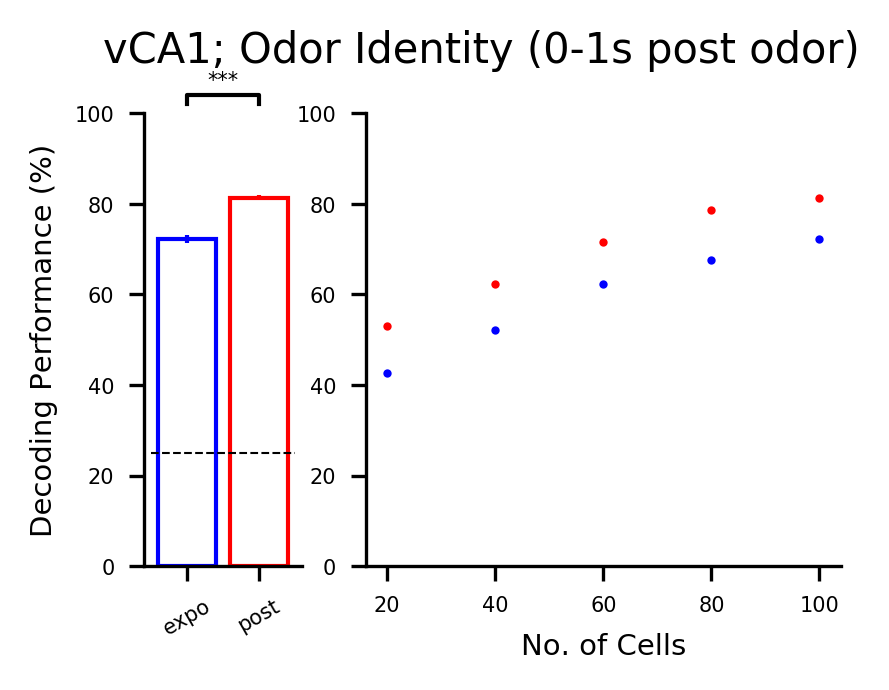

In [32]:
reg='vhpc'
t=5
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("scores_%s_1s_expo_%s_100cells_appended"%(reg,t))),
                     (eval("scores_%s_1s_post_%s_100cells_appended"%(reg,t))),
                     sess1='expo',sess2='post', chance=25, ax=axs[0])

for cr,c in zip(['expo','post'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1; Odor Identity (0-1s post odor)", fontsize=10,y=1.02)

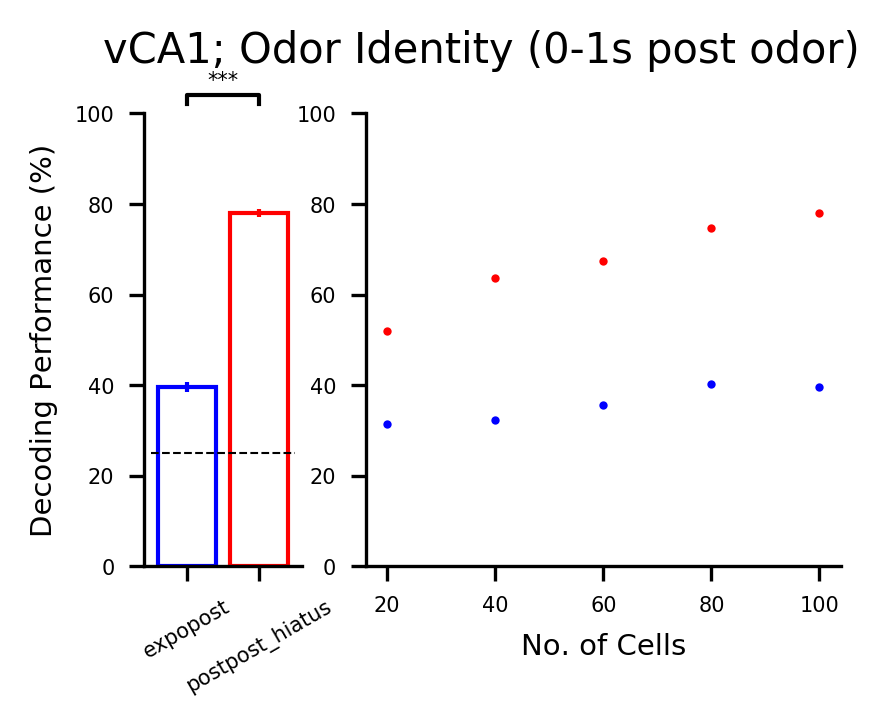

In [33]:
reg='vhpc'
t=5
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=25, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1; Odor Identity (0-1s post odor)", fontsize=10,y=1.02)

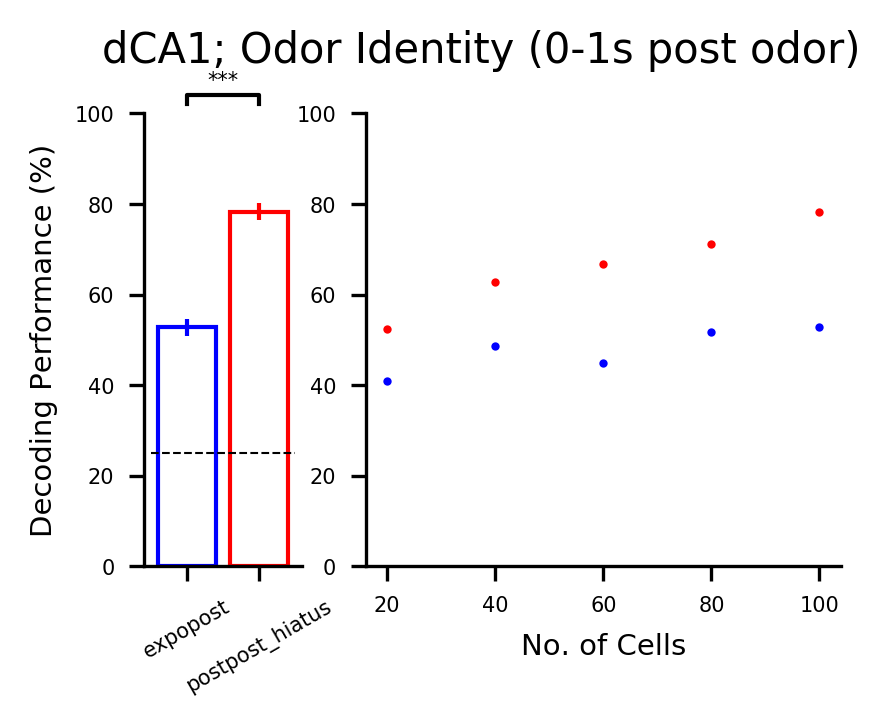

In [34]:
reg='dhpc'
t=5
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=25, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("dCA1; Odor Identity (0-1s post odor)", fontsize=10,y=1.02)

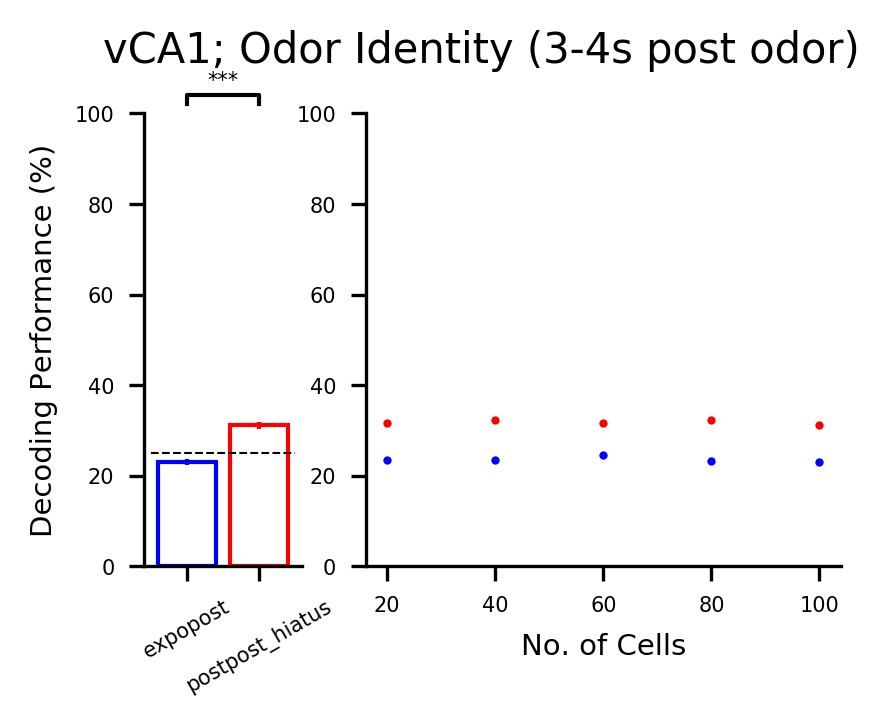

In [37]:
reg='vhpc'
t=8
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=25, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1; Odor Identity (3-4s post odor)", fontsize=10,y=1.02)

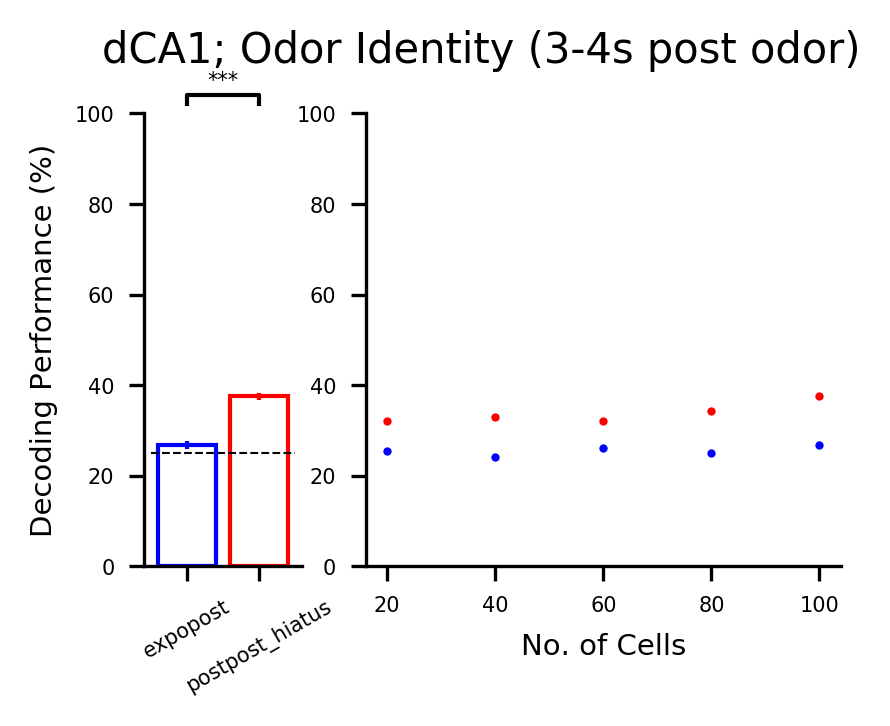

In [38]:
reg='dhpc'
t=8
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=25, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("dCA1; Odor Identity (3-4s post odor)", fontsize=10,y=1.02)

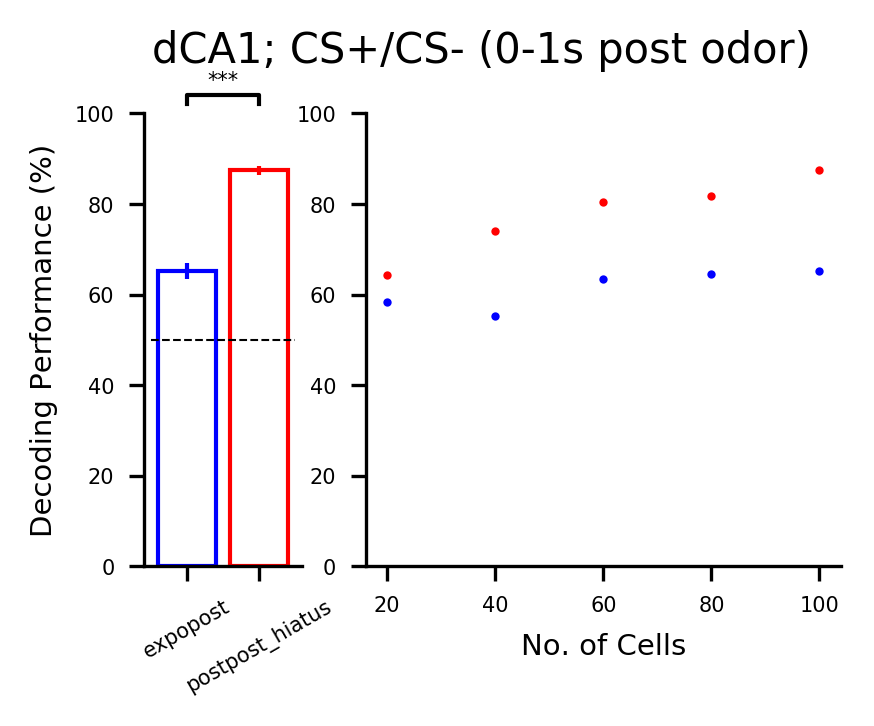

In [39]:
reg='dhpc'
t=5
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=50, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("CSpm_scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("dCA1; CS+/CS- (0-1s post odor)", fontsize=10,y=1.02)

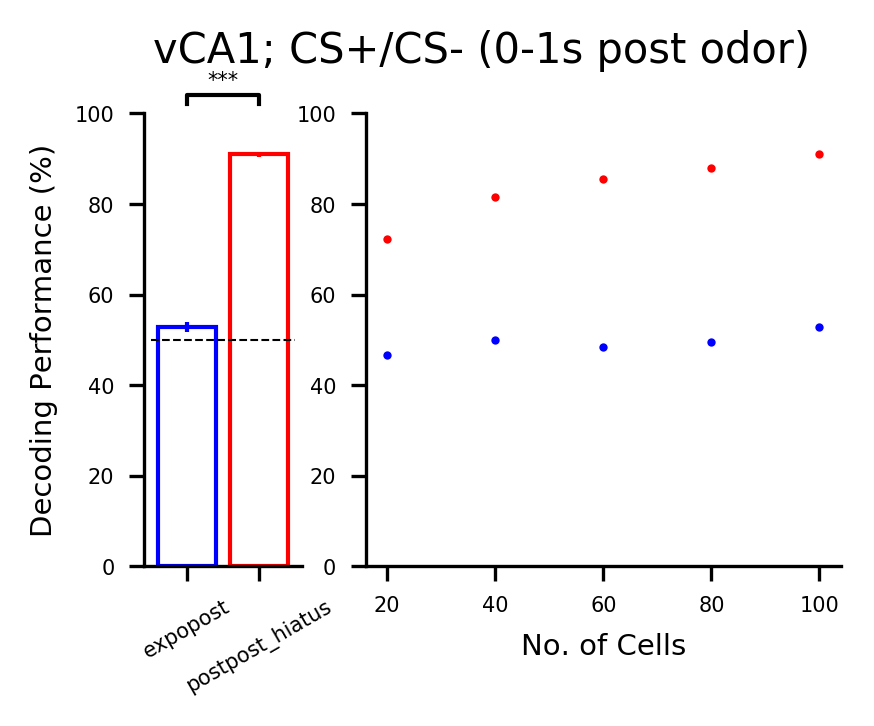

In [40]:
reg='vhpc'
t=5
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=50, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("CSpm_scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1; CS+/CS- (0-1s post odor)", fontsize=10,y=1.02)

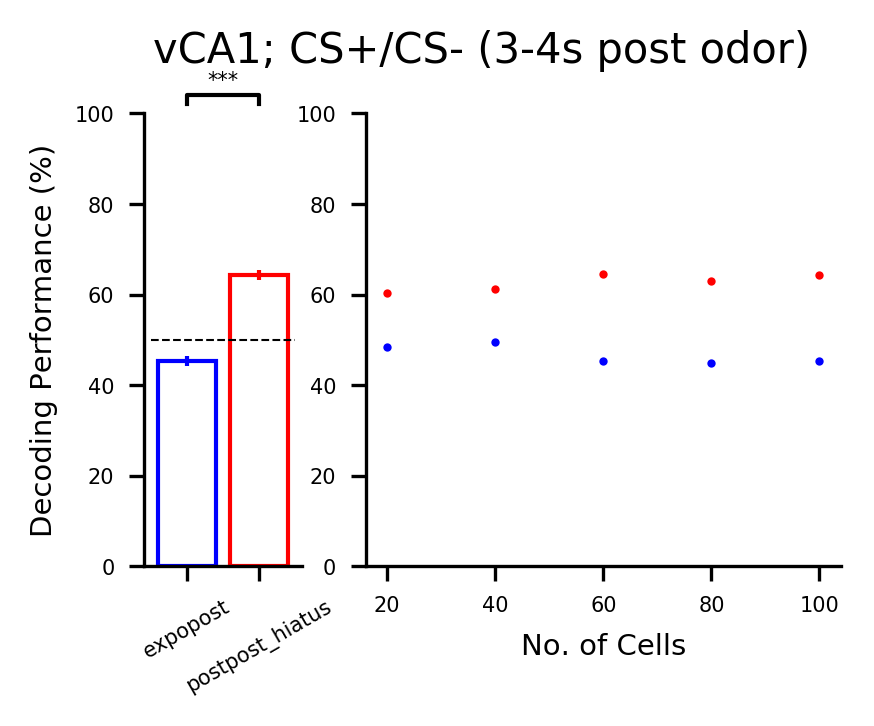

In [41]:
reg='vhpc'
t=8
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=50, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("CSpm_scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("vCA1; CS+/CS- (3-4s post odor)", fontsize=10,y=1.02)

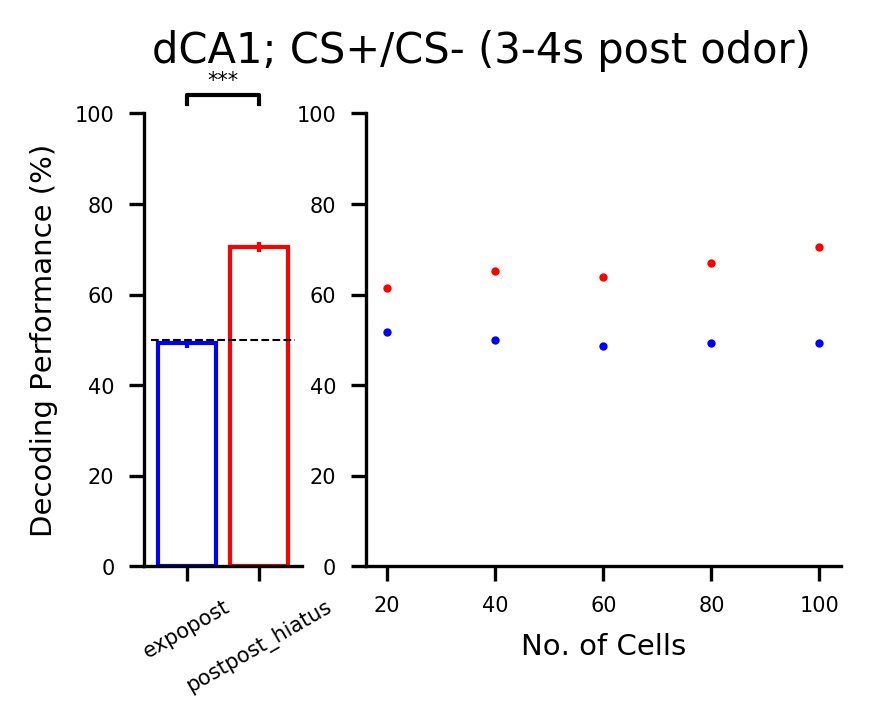

In [42]:
reg='dhpc'
t=8
n_loops=loops

fig, axs = pl.subplots(1, 2, figsize=(3, 2), gridspec_kw={'width_ratios':[1,3]})

plot_scores_compare2((eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended"%(reg,t))),
                     (eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended"%(reg,t))),
                     sess1='expopost',sess2='postpost_hiatus', chance=50, ax=axs[0])

for cr,c in zip(['expopost','postpost_hiatus'],['b','r']):
    for q,i in zip(cell_quant,range(len(cell_quant))):
            axs[1].plot(cell_quant[i],np.mean(eval("CSpm_scores_%s_1s_%s_%s_%scells_appended"%(reg,cr,t,q)))*100,'o', ms=2, mew=0,color=c)
axs[1].set_ylim(0,100)
axs[1].set_xlabel("No. of Cells")

fig.suptitle("dCA1; CS+/CS- (3-4s post odor)", fontsize=10,y=1.02)

U = 0.0 p = 0.00018267179111 r = -0.845154254729
U = 4.0 p = 0.000582839943179 r = -0.77754191435


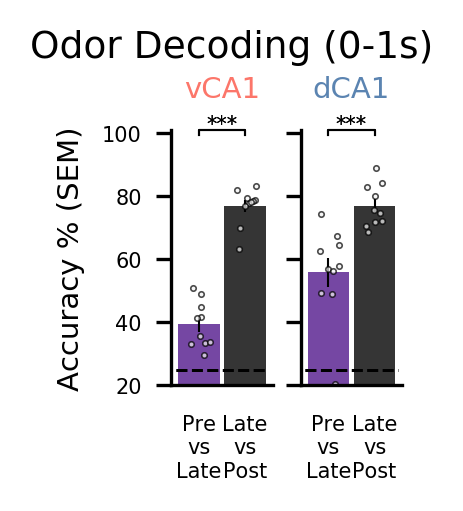

In [54]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
width=.9
for reg,r,eco in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la,co in zip(range(2),['expopost','postpost_hiatus'],['expo','Post'],['rebeccapurple',[.12,.12,.12]]):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_1s_%s_%s_100cells_appended[:loops])*100/np.sqrt(loops-1))"%(t,reg,sess,reg,sess,t))
            ax[r].errorbar(i,np.mean(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expopost','postpost_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)),0,1,q))
    report_stats(eval("scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),['expo','post','post_hiatus']):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (0-1s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_odor_ExPoHi_100cells.pdf'%NOTEBOOK_NAME)

U = 7.0 p = 0.00129842563008 r = -0.726832659067
U = 10.0 p = 0.00280656223759 r = -0.676123403783


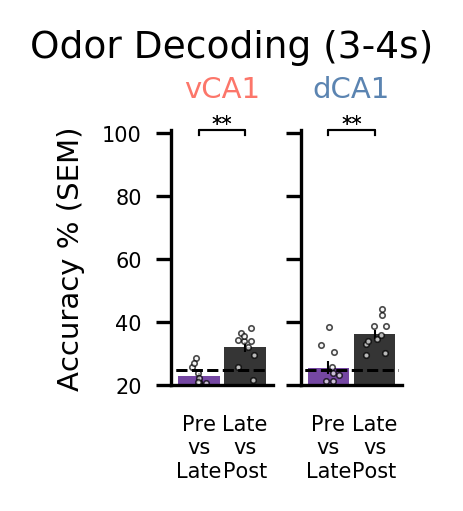

In [55]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
width=.9
for reg,r,eco in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la,co in zip(range(2),['expopost','postpost_hiatus'],['expo','Post'],['rebeccapurple',[.12,.12,.12]]):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(scores_%s_1s_%s_%s_100cells_appended[:loops])*100/np.sqrt(loops-1))"%(t,reg,sess,reg,sess,t))
            ax[r].errorbar(i,np.mean(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(25, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expopost','postpost_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)),0,1,q))
    report_stats(eval("scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),['expo','post','post_hiatus']):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.03,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.03,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Odor Decoding (3-4s)", fontsize=9, y=1.05)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_tr_ExPoHi_100cells.pdf'%NOTEBOOK_NAME)

U = 0.0 p = 0.000180634720808 r = -0.845154254729
U = 3.0 p = 0.000439638752627 r = -0.794444999445


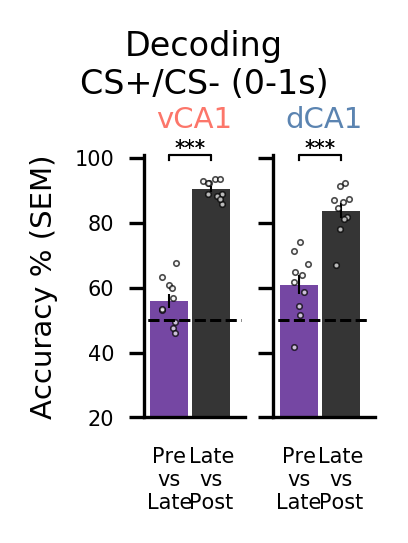

In [56]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
t=5 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,eco in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la,co in zip(range(2),['expopost','postpost_hiatus'],['expo','Post'],['rebeccapurple',[.12,.12,.12]]):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops])*100/np.sqrt(loops-1))"%(t,reg,sess,reg,sess,t))
            ax[r].errorbar(i,np.mean(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expopost','postpost_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)),0,1,q))
    report_stats(eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),['expo','post','post_hiatus']):
#        pvs.append(sig_vs_chance(ax[r],eval("CSpm_scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("CSpm_scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.01,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.01,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding\nCS+/CS- (0-1s)", fontsize=8, y=1.12)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSpm_odor_ExPoHi_100cells.pdf'%NOTEBOOK_NAME)

U = 6.0 p = 0.00100797624038 r = -0.743735744161
U = 0.0 p = 0.000181651146091 r = -0.845154254729


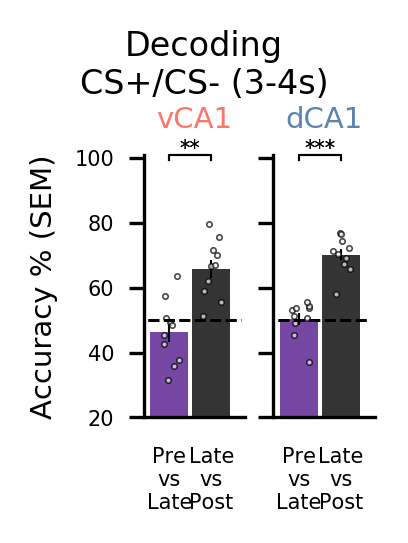

In [53]:
fig, ax = pl.subplots(1,2, figsize=(1.3, 1.5),sharey=True)
loops=10
tb='1s'
t=8 #time bin to plot (5 = 0-1s post odor delivery)
sess='post'
width=.9
for reg,r,eco in zip(['vhpc','dhpc'],range(2),['#FC766AFF','#5B84B1FF']):
    for i,sess,la,co in zip(range(2),['expopost','postpost_hiatus'],['expo','Post'],['rebeccapurple',[.12,.12,.12]]):
        #for i,t,c,la in zip(range(2),[5,8],['k','k'],['CS','Trace']):
            ax[r].bar(i,np.mean(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,width=.9,
                      color=co,alpha=.9,label=la)
            exec("s_%s_%s_%s = np.array(np.std(CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops])*100/np.sqrt(loops-1))"%(t,reg,sess,reg,sess,t))
            ax[r].errorbar(i,np.mean(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,yerr=eval('s_%s_%s_%s'%(t,reg,sess)),color='k')
            ax[r].scatter(i+np.random.random(loops)*width/2-width/4.5,np.array(eval("CSpm_scores_%s_1s_%s_%s_100cells_appended[:loops]"%(reg,sess,t)))*100,
               color='whitesmoke',s=1.7,zorder=2,alpha=.7,linewidths=.4,edgecolor='k')
            
for x in range (2):
    for y in range(2):
        ax[x].set_ylim(20, 101)
        #ax[x].set_xlim(-5, 9)
        ax[x].hlines(50, -0.5,1.7, color='k', lw=.7, linestyles='dashed')
        #ax[x].set_xlabel('Comparison')
        ax[0].set_ylabel('Accuracy % (SEM)')
        ax[x].set_xticks([0,1])
        ax[x].set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'])
        ax[x].tick_params(axis='x',bottom='off')

pvs=[]
sess=['expopost','postpost_hiatus']
for reg,r in zip(['vhpc','dhpc'],range(2)):
    for q in [101,101]:
        pvs.append(add_significance(ax[r], eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)),0,1,q))
    report_stats(eval("CSpm_scores_%s_1s_expopost_%s_100cells_appended[:loops]"%(reg,t)),
                    eval("CSpm_scores_%s_1s_postpost_hiatus_%s_100cells_appended[:loops]"%(reg,t)))
#for i,t,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),['expo','post','post_hiatus']):
#        pvs.append(sig_vs_chance(ax[r],eval("CSpm_scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k))[-loops:],.5,i,
#               np.mean(eval("CSpm_scores_tb_%s_lmin_outcome_averaged[sess][-loops:]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('vCA1', y=1.01,color='#FC766AFF')
ax[1].set_title('dCA1', y=1.01,color='#5B84B1FF')
#ax[1].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding\nCS+/CS- (3-4s)", fontsize=8, y=1.12)

fig.tight_layout(pad=1)

fig.savefig('../figures/%s_CSpm_trace_ExPoHi_100cells.pdf'%NOTEBOOK_NAME)

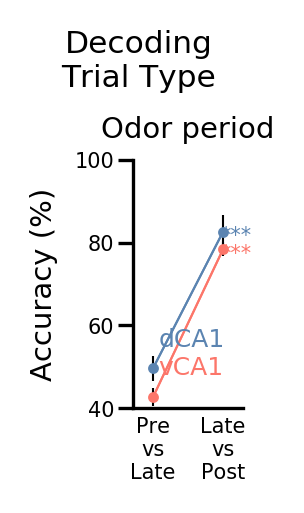

In [49]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expopost','postpost_hiatus'
tb='1s'
t=5
tb_la='Odor'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(25, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(40,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'],fontsize=5)
        #ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("scores_vhpc_1s_expopost_%s_100cells_appended[-loops:]"%(t)),
   eval("scores_vhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)),
   1.23,np.mean(eval("scores_vhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)))*100-2.5,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("scores_dhpc_1s_expopost_%s_100cells_appended[-loops:]"%(t)),
   eval("scores_dhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)),
   1.23,np.mean(eval("scores_dhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)))*100-2.5,color='#5B84B1FF'))

ax.text(.45,48,'vCA1',color='#FC766AFF',fontsize=6)
ax.text(.45,55,'dCA1',color='#5B84B1FF',fontsize=6)

fig.suptitle('Decoding\nTrial Type',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_odor.pdf'%NOTEBOOK_NAME)

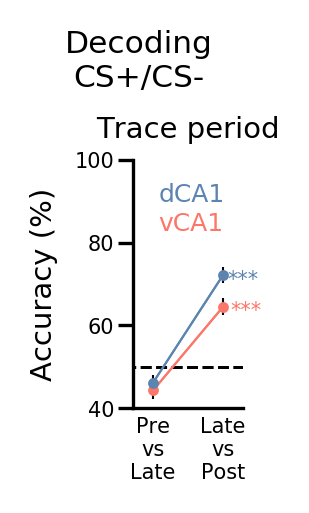

In [50]:
fig,ax = pl.subplots(1,1,figsize=(1,1.5),sharey=True)
v={}
d={}
loops=10
expectations = 'expopost','postpost_hiatus'
tb='1s'
t=8
tb_la='Trace'
# Add connecting lines            
for ex,z in zip(expectations,(.4,1.1)):
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("CSpm_scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100 for ex in expectations],
                   color='#5B84B1FF')
        ax.plot([p for p in (.4,1.1)],[np.mean(eval("CSpm_scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100 for ex in expectations],
                   color='#FC766AFF')
for ex,z in zip(expectations,(.4,1.1)):            
        v[ex] = np.std(eval("CSpm_scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100/np.sqrt(loops)
        d[ex] = np.std(eval("CSpm_scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100/np.sqrt(loops)
        ax.plot(z, np.mean(eval("CSpm_scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100, 'o',
                   color='#FC766AFF',mec='#FC766AFF',markersize=2,mew=0.6)
        ax.plot(z, np.mean(eval("CSpm_scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100, 'o',
                   color='#5B84B1FF',mec='#5B84B1FF',markersize=2,mew=0.6)            
        ax.errorbar(z, np.mean(eval("CSpm_scores_vhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100,yerr=v[ex],color='k')  
        ax.errorbar(z, np.mean(eval("CSpm_scores_dhpc_1s_%s_%s_100cells_appended[-loops:]"%(ex,t)))*100,yerr=d[ex],color='k')  
        ax.hlines(50, -0.5,1.5, color='k', lw=.7, linestyles='dashed')
        ax.tick_params(axis='x',bottom=False,pad=-1.5) # labels along the bottom edge are off
        ax.tick_params(axis='y',pad=1) # labels along the bottom edge are off
        ax.set_ylabel('Accuracy (%)')
        ax.set_ylim(40,100)
        ax.set_title(tb_la+" period",y=.99)
        ax.set_xlim(0.2,1.3)
        ax.set_xticks((.4,1.1))
        ax.set_xticklabels(['Pre\nvs\nLate','Late\nvs\nPost'],fontsize=5)
        #ax.set_xlabel("Session")
            
from matplotlib.lines import Line2D

pvs=[]
pvs.append(add_significance_point(ax,eval("CSpm_scores_vhpc_1s_expopost_%s_100cells_appended[-loops:]"%(t)),
   eval("CSpm_scores_vhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)),
   1.33,np.mean(eval("CSpm_scores_vhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)))*100-2.5,color='#FC766AFF'))
pvs.append(add_significance_point(ax,eval("CSpm_scores_dhpc_1s_expopost_%s_100cells_appended[-loops:]"%(t)),
   eval("CSpm_scores_dhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)),
   1.3,np.mean(eval("CSpm_scores_dhpc_1s_postpost_hiatus_%s_100cells_appended[-loops:]"%(t)))*100-2.5,color='#5B84B1FF'))

ax.text(.45,83,'vCA1',color='#FC766AFF',fontsize=6)
ax.text(.45,90,'dCA1',color='#5B84B1FF',fontsize=6)

fig.suptitle('Decoding\nCS+/CS-',fontsize=7.5,y=1.1)
fig.tight_layout(pad=2)

fig.savefig('../figures/%s_lines_CSpm_trace.pdf'%NOTEBOOK_NAME)

In [51]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'IPython'. Skipping...
